# <font style="color:blue">SSD using PyTorch Hub</font>

In this notenook, we will inference the SSD model using PyTorch Hub.

First, we will see what PyTorch Hub is. Then we will load the SSD model from [NVIDIA/DeepLearningExamples:torchhub](https://github.com/NVIDIA/DeepLearningExamples/tree/torchhub) GitHub repository using PyTorch Hub make inference on a few sample data.

# <font style="color:blue">1. Introduction to PyTorch Hub</font>

- Pytorch Hub is an API that provides pre-trained models to facilitate research reproducibility. 


- It has built-in support for [Colab](https://colab.research.google.com/) and [Paper with Code](https://paperswithcode.com/).


- It has a broad set model that includes classification, detection, segmentation, etc. Get list of available model [here](https://pytorch.org/hub/research-models/compact)

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-pytorch-hub.png'>

---

- It also supports publishing a pre-trained model to a Github repository. Get details [here](https://pytorch.org/docs/stable/hub.html).


## <font style="color:green">List Supported Model</font>

PyTorch Hub APIs only work if repository has hubconf.py file, for example [hubconf.py](https://github.com/NVIDIA/DeepLearningExamples/blob/torchhub/hubconf.py) file in [NVIDIA/DeepLearningExamples:torchhub](https://github.com/NVIDIA/DeepLearningExamples/tree/torchhub).

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import torch

In [3]:
torch.hub.list(github='NVIDIA/DeepLearningExamples:torchhub', force_reload=False)

Using cache found in /home/prakash/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


['checkpoint_from_distributed',
 'nvidia_ncf',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_waveglow',
 'unwrap_distributed']

## <font style="color:green">Get Model Description</font>

In [4]:
torch.hub.help(github='NVIDIA/DeepLearningExamples:torchhub', 
               model='nvidia_ssd', 
               force_reload=False)

Using cache found in /home/prakash/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


"Constructs an SSD300 model.\n    For detailed information on model input and output, training recipies, inference and performance\n    visit: github.com/NVIDIA/DeepLearningExamples and/or ngc.nvidia.com\n\n    Args:\n        pretrained (bool, True): If True, returns a model pretrained on COCO dataset.\n        model_math (str, 'fp32'): returns a model in given precision ('fp32' or 'fp16')\n    "

# <font style="color:blue">2. SSD model Inference using PyTorch Hub</font>

- We are already familiar with SSD (Single Shot MultiBox Detector). You can find the paper [here](https://arxiv.org/pdf/1512.02325.pdf). 

---

<img src=https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-ssd.png width=1000>

<center>Image credits: Liu et al</center>

---


- We will use the pre-trained SSD model by Nvidia. You can find other different models from Nvidia [here](https://github.com/NVIDIA/DeepLearningExamples/tree/torchhub/PyTorch).


- SSD implementation of Nvidia is a variant of [the original paper](https://arxiv.org/pdf/1512.02325.pdf). 


## <font style="color:green">Model Description</font>

This SSD300 model is based on the
[SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper, which
describes SSD as "a method for detecting objects in images using a single deep neural network".
The input size is fixed to `300x300`.

The main difference between this model and the one described in the paper is in the backbone.
Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

From the
[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)
paper, the following enhancements were made to the backbone:
*   The `conv5_x`, `avgpool`, `fc` and softmax layers were removed from the original classification model.
*   All strides in `conv4_x` are set to `1x1`. 

The backbone is followed by 5 additional convolutional layers.
In addition to the convolutional layers, we attached 6 detection heads:
*   The first detection head is attached to the last `conv4_x` layer.
*   The other five detection heads are attached to the corresponding `5` additional layers.

Detector heads are similar to the ones referenced in the paper, however,
they are enhanced by additional BatchNorm layers after each convolution.

**If you are interested in original SSD paper implementation, you can find [here](https://github.com/amdegroot/ssd.pytorch/blob/master/ssd.py).**

## <font style="color:green">Load the Model using PyTorch Hub</font>

- The model has been trained on two precession- `float16` (`fp16`) and `float32` (`fp32`).


- The benefit of `fp16` is heigh inference speed compare to `fp32` at the cost of accuracy/precision. 


- Setting precision=`fp16` will load a checkpoint trained with [mixed precision](https://arxiv.org/abs/1710.03740) into architecture enabling execution on [Tensor Cores](https://developer.nvidia.com/tensor-cores).
Handling mixed precision data requires [Apex](https://github.com/NVIDIA/apex) library.



Let's load the SSD (by Nvidia) model using PyTorch Hub.


In [5]:
precision = 'fp32'
ssd = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Using cache found in /home/prakash/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


## <font style="color:green">Load the Utils Function</font>

In [6]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /home/prakash/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [7]:
ssd.to('cuda')
ssd.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

## <font style="color:green">Input Images</font>

- Pre-process inputs images for SSD object detection.


- Here, Image URLs have been used. You can use your images. 


In [8]:
urls = [
    'http://images.cocodataset.org/test2017/000000550803.jpg',
    'http://images.cocodataset.org/test2017/000000004053.jpg',
    'http://images.cocodataset.org/test2017/000000426603.jpg',
    'http://images.cocodataset.org/test2017/000000491276.jpg'
]

### <font style="color:green">Image Pre-process</font>

In [9]:
inputs = [utils.prepare_input(url) for url in urls]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

## <font style="color:green">Inference</font>

In [10]:
with torch.no_grad():
    detections = ssd(tensor)

### <font style="color:green">Image Post-process</font>

In [11]:
results = utils.decode_results(detections)
best_results = [utils.pick_best(results, 0.40) for results in results]

## <font style="color:green">Get Class to Label Map</font>

In [12]:
classes_to_labels = utils.get_coco_object_dictionary()

## <font style="color:green">Plot Detections</font>

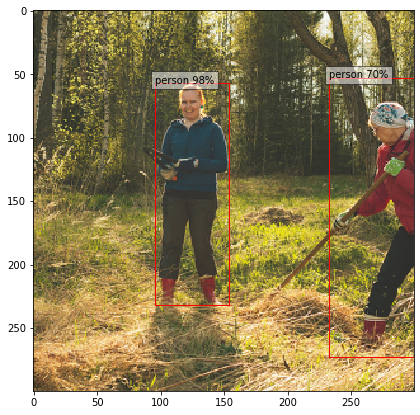

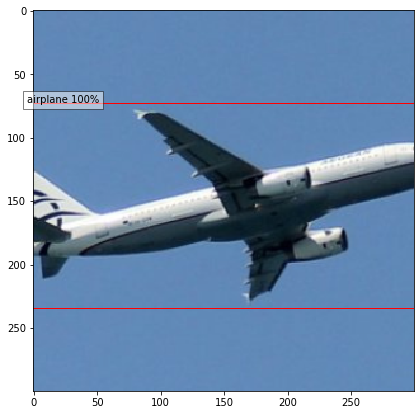

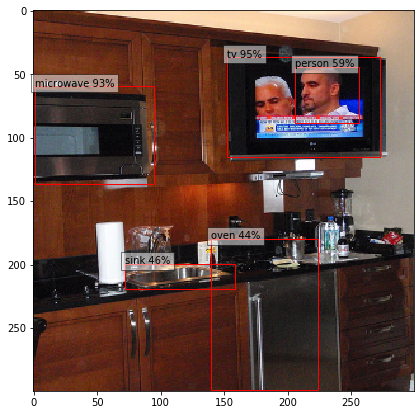

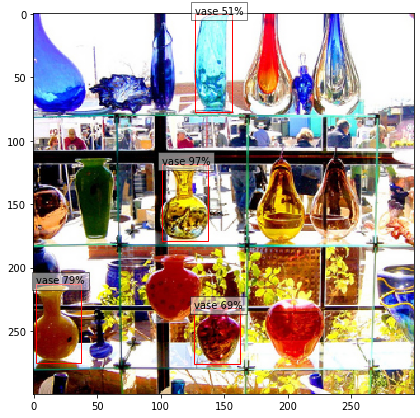

In [13]:
for image_idx in range(len(best_results)):
    fig, ax = plt.subplots(1, figsize=(7,7))
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

# <font style="color:blue">References</font>

- [SSD: Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf)


- [PyTorch Hub](https://pytorch.org/docs/stable/hub.html)


- [NVIDIA DeepLearningExamples:PyTorch SSD](https://github.com/NVIDIA/DeepLearningExamples/tree/torchhub/PyTorch/Detection/SSD)


- [PyTorch Hub: Docs](https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/)


- [PyTorch Blog: Towards reproducible research with pytorch hub](https://pytorch.org/blog/towards-reproducible-research-with-pytorch-hub/)


- [SSD PyTorch Github](https://github.com/amdegroot/ssd.pytorch/blob/master/ssd.py)